# Coding: Language Model based on LSTM

 - Dataset: WikiText-2
 - Model: LSTM/GRU
 - Optimizer: Adam
 - Learning Rate: 0.001
 - Batch Size: 64
 - Epochs: 10
 - Dropout: 0.2

In [4]:
# 可以先测试网络连接
import requests
try:
    response = requests.get("https://huggingface.co")
    print("网络连接正常")
except:
    print("网络连接可能存在问题")

网络连接正常


In [6]:
# Load WikiText-2 Dataset using Hugging Face datasets

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
import re

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load WikiText-2 dataset from Hugging Face
print("Loading WikiText-2 dataset from Hugging Face...")
dataset = load_dataset("wikitext", "wikitext-2-v1",cache_dir="D:\Developer\LLM\FuggingFace-cache-model")

# Access the splits
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a sample
# Find a non-empty sample
print(f"\nLooking for non-empty samples...")
sample_text = None
for i, example in enumerate(train_dataset):
    if example["text"].strip ():    # Find first non-empty line
        sample_text = example["text"]
        print(f"Found non-empty sample at index {i}")
        break
print(f"First sample: {sample_text[:200]}")

# Basic tokenization function
def basic_tokenize(text):
    # Convert to lowercase and split on whitespace and punctuation
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from training data
print("\nBuilding vocabulary...")
all_tokens = []
non_empty_lines = 0
for example in train_dataset:
    if example['text'].strip():  # Skip empty lines
        tokens = basic_tokenize(example['text'])
        all_tokens.extend(tokens)
        non_empty_lines += 1

# Create vocabulary
vocab_counter = Counter(all_tokens)
vocab_size = len(vocab_counter)
print(f"Non-empty lines: {non_empty_lines}")
print(f"Total tokens: {len(all_tokens)}")
print(f"Vocabulary size: {vocab_size}")

# Create word to index mapping
vocab = {'<unk>': 0, '<pad>': 1}
for word, count in vocab_counter.most_common():
    if word not in vocab:
        vocab[word] = len(vocab)

# Create index to word mapping
idx_to_word = {idx: word for word, idx in vocab.items()}

print(f"Final vocabulary size (with special tokens): {len(vocab)}")
print(f"Most common words: {list(vocab_counter.most_common(10))}")

# Function to convert text to indices
def text_to_indices(text, vocab):
    tokens = basic_tokenize(text)
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# Convert a sample to see the tokenization
sample_indices = text_to_indices(sample_text, vocab)
print(f"\nSample tokenization:")
print(f"Original: {sample_text[:100]}")
print(f"Tokens: {basic_tokenize(sample_text)[:20]}")
print(f"Indices: {sample_indices[:20]}")

print("\nDataset loaded successfully!")

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\74178\AppData\Local\Temp\ipykernel_9880\2840440284.py:15: SyntaxWarning: invalid escape sequence '\D'
  dataset = load_dataset("wikitext", "wikitext-2-v1",cache_dir="D:\Developer\LLM\FuggingFace-cache-model")


Using device: cpu
Loading WikiText-2 dataset from Hugging Face...
Train dataset size: 36718
Validation dataset size: 3760
Test dataset size: 4358

Looking for non-empty samples...
Found non-empty sample at index 1
First sample:  = Valkyria Chronicles III = 


Building vocabulary...
Non-empty lines: 23767
Total tokens: 1750345
Vocabulary size: 28710
Final vocabulary size (with special tokens): 28712
Most common words: [('the', 130768), ('of', 57030), ('unk', 54625), ('and', 50735), ('in', 45015), ('to', 39521), ('a', 36523), ('was', 21008), ('on', 15140), ('as', 15058)]

Sample tokenization:
Original:  = Valkyria Chronicles III = 

Tokens: ['valkyria', 'chronicles', 'iii']
Indices: [3767, 3830, 860]

Dataset loaded successfully!


In [7]:
# Data Preprocess & Init DataLoader

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class WikiTextDataset(Dataset):
    def __init__(self, hf_dataset, vocab, sequence_length=50):
        """
        Custom Dataset for WikiText-2

        Args:
            hf_dataset: Hugging Face dataset split
            vocab: vocabulary dictionary
            sequence_length: length of input sequences
        """
        self.vocab = vocab
        self.sequence_length = sequence_length

        # Process all text and create sequences
        self.sequences = []
        self.targets = []

        print(f"Processing dataset with sequence length: {sequence_length}")

        # Concatenate all non-empty text and tokenize
        all_indices = []
        for example in hf_dataset:
            if example['text'].strip():  # Skip empty lines
                indices = text_to_indices(example['text'], vocab)
                all_indices.extend(indices)

        print(f"Total tokens in dataset: {len(all_indices)}")

        # Create sequences of specified length
        for i in range(len(all_indices) - sequence_length):
            # Input sequence
            seq = all_indices[i:i + sequence_length]
            # Target is the next token
            target = all_indices[i + sequence_length]

            self.sequences.append(seq)
            self.targets.append(target)

        print(f"Created {len(self.sequences)} sequences")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )

# Create datasets
sequence_length = 50
batch_size = 64

print("Creating training dataset...")
train_wiki_dataset = WikiTextDataset(train_dataset, vocab, sequence_length)

print("\nCreating validation dataset...")
val_wiki_dataset = WikiTextDataset(val_dataset, vocab, sequence_length)

print("\nCreating test dataset...")
test_wiki_dataset = WikiTextDataset(test_dataset, vocab, sequence_length)

# Create DataLoaders
train_loader = DataLoader(
    train_wiki_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to 0 for compatibility
)

val_loader = DataLoader(
    val_wiki_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_wiki_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"\nDataLoader Summary:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Sequence length: {sequence_length}")

# Test the DataLoader
for batch_idx, (sequences, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Sequences shape: {sequences.shape}")
    print(f"  Targets shape: {targets.shape}")
    print(f"  Sample sequence: {sequences[0][:10].tolist()}")
    print(f"  Sample target: {targets[0].item()}")

    # Convert back to words for verification
    sample_words = [idx_to_word[idx.item()] for idx in sequences[0]]
    target_word = idx_to_word[targets[0].item()]
    print(f"  Sample words: {sample_words}")
    print(f"  Target word: {target_word}")
    break  # Only show first batch

print("\nDataLoader created successfully!")

Creating training dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 1750345
Created 1750295 sequences

Creating validation dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 183606
Created 183556 sequences

Creating test dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 206381
Created 206331 sequences

DataLoader Summary:
Training batches: 27349
Validation batches: 2869
Test batches: 3224
Batch size: 64
Sequence length: 50
Batch 1:
  Sequences shape: torch.Size([64, 50])
  Targets shape: torch.Size([64])
  Sample sequence: [1635, 479, 3249, 40, 5913, 2468, 548, 91, 38, 2]
  Sample target: 3
  Sample words: ['organized', 'human', 'criminal', 'or', 'rebel', 'opposition', 'ten', 'years', 'after', 'the', 'official', 'end', 'of', 'the', 'zombie', 'war', 'millions', 'of', 'zombies', 'are', 'still', 'active', 'mainly', 'on', 'the', 'ocean', 'floor', 'or', 'on', 'snow', 'line', 'islands', 'a', 'democratic'

In [8]:
# GRU Language Model Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.2):
        """
        GRU-based Language Model for next word prediction

        Args:
            vocab_size: Size of vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Hidden dimension of GRU
            num_layers: Number of GRU layers
            dropout: Dropout probability
        """
        super(GRULanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Word embedding layer
        """
        词嵌入层（Embedding Layer）在自然语言处理中非常重要，主要原因如下：
        1. 将离散符号转换为连续向量
            问题: 单词在计算机中以离散的整数索引形式存在（如 "the"=1, "cat"=2），这些数字本身没有语义信息
            解决方案: 词嵌入层将这些离散索引映射到连续的向量空间中，每个词对应一个密集向量
        2. 捕获语义信息
            语义相似的词在向量空间中距离较近
            可以通过向量运算发现词之间的关系（如 "king" - "man" + "woman" ≈ "queen"）
            相比 one-hot 编码，嵌入向量能表达更丰富的语义信息
        3. 降低维度和提高效率
            One-hot 编码问题: 如果词汇表有 28,712 个词，one-hot 向量需要同样多的维度，且非常稀疏
            嵌入向量优势: 通常使用 128-512 维的密集向量，大大降低计算复杂度
        4. 为神经网络提供可学习的输入表示
        """
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layer(s)
        """
        GRU 的序列处理机制
        1. 逐时间步处理，而非逐词处理
            虽然输入是词嵌入向量，但GRU实际上是按时间步(time step)处理，每个时间步处理一个词嵌入：
                # 输入序列形状: [batch_size, seq_len, embedding_dim]
                # 例如: [64, 50, 128] 表示批次大小64，序列长度50，嵌入维度128

                # GRU在内部这样处理:
                # 时间步0: 处理第0个词的嵌入向量 [64, 128]
                # 时间步1: 处理第1个词的嵌入向量 [64, 128] + 前一时间步的隐藏状态
                # ...
                # 时间步49: 处理第49个词的嵌入向量 [64, 128] + 前一时间步的隐藏状态
        2. 每个时间步都有输出
            GRU在每个时间步都会产生输出，而不是等到整个序列处理完才输出：
                # GRU输出:
                # gru_output: [batch_size, seq_len, hidden_dim] - 每个时间步都有输出
                # hidden: [num_layers, batch_size, hidden_dim] - 最终隐藏状态
        3. 序列到序列的处理
            GRU是序列到序列的模型：
                输入: 整个序列的所有词嵌入 [64, 50, 128]
                处理: 按时间步逐个处理，每个时间步利用前一时间步的信息
                输出: 每个时间步都产生输出 [64, 50, 256]
        4. 在语言模型中的应用
            在当前的语言模型中：
                # 对于序列 "the cat sat on the mat"
                # 输入序列: ["the", "cat", "sat", "on", "the"] (前5个词)
                # 目标序列: ["mat"] (第6个词)

                # GRU处理完整序列后:
                # 输出每个位置的隐藏状态，用于预测下一个词
                # 最后一个时间步的输出用于预测目标词"mat"
        5. 关键理解点
            并行输入: 整个序列一次性输入到GRU
            串行处理: GRU内部按时间步顺序处理，每个时间步依赖前一个时间步的隐藏状态
            并行输出: 所有时间步的输出同时产生
            预测机制: 通常使用最后一个时间步的输出来预测下一个词
            所以，GRU不是等完整序列处理完才输出，而是在处理序列的过程中，每个时间步都产生输出，这些输出可以用于不同目的（如序列标注、下一个词预测等）。
        """
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)

        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights"""
        # Initialize embedding weights
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)      # 对嵌入层权重进行均匀分布初始化

         # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)          # 对GRU层参数进行正交初始化（权重）
            elif 'bias' in name:
                nn.init.zeros_(param)                   # 对GRU层参数进行零初始化（偏置）

        # Initialize output layer 对输出层使用Xavier均匀初始化（权重）和零初始化（偏置）
        nn.init.xavier_uniform_(self.output_projection.weight)
        nn.init.zeros_(self.output_projection.bias)

    def forward(self, input_ids, hidden=None):
        """
        Forward pass

        Args:
            input_ids: Input token indices [batch_size, seq_len]
            hidden: Hidden state from previous step

        Returns:
            logits: Output logits [batch_size, seq_len, vocab_size]
            hidden: Final hidden state
        """
        batch_size, seq_len = input_ids.size()

        # Word embeddings，将每个词的索引映射为对应的词向量 索引值->embedding_dim大小（维）的词向量
        embeddings = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # GRU forward pass, 2 layers by default
        gru_output, hidden = self.gru(embeddings, hidden)  # [batch_size, seq_len, hidden_dim], [num_layers, batch_size, hidden_dim]

        # Apply dropout to GRU output   对GRU输出应用dropout。
        """
        1. 正则化防止过拟合
            问题: 神经网络在训练过程中容易过拟合，即在训练数据上表现很好，但在新数据上表现较差
            解决方案: Dropout通过随机将一部分神经元输出置为0，强制网络不依赖特定的神经元路径
        2. Dropout的工作原理
            # Dropout层定义 (在__init__中):
            self.dropout_layer = nn.Dropout(dropout)  # dropout=0.2

            # 在训练时:
            # gru_output形状: [64, 50, 256] (batch_size, seq_len, hidden_dim)
            # Dropout会随机将20%的元素置为0，其余元素乘以1/(1-0.2)=1.25
            # 这样保持期望值不变，但增加了随机性
        3. 在GRU输出上的应用
            对于当前模型：
            输入: gru_output 形状为 [64, 50, 256]
            处理: 每个元素有20%的概率被置为0
            输出: 同样形状的张量，部分值被置零，其余值被缩放
        4. 训练vs推理阶段
            # 训练阶段 (model.train()):
            # Dropout生效，随机置零部分元素
            gru_output = self.dropout_layer(gru_output)  # 应用dropout

            # 推理阶段 (model.eval()):
            # Dropout不生效，所有元素都保留
            gru_output = self.dropout_layer(gru_output)  # 无效果，直接返回输入
        5. 为什么在GRU后应用Dropout
            防止特征共适应: 避免GRU层的输出过度依赖特定的特征组合
            增强泛化能力: 使模型对输入的小变化更加鲁棒
            减少过拟合: 特别是在模型参数较多时（当前模型有1170万参数）
        6. 实际效果示例
            # 假设GRU输出的一部分:
            # [[0.5, -1.2, 2.1, 0.8],[1.3, 0.4, -0.9, 1.7]]

            # 应用dropout (假设dropout率=0.2):
            # [[0.0, -1.2, 2.1, 0.0],[1.3, 0.0, -0.9, 1.7]]  # 部分元素置零,其余非零元素可能被缩放

            # 最终输出给下一层的值发生变化，增加了训练的随机性
        """
        gru_output = self.dropout_layer(gru_output)

        # Project to vocabulary size
        logits = self.output_projection(gru_output)  # [batch_size, seq_len, vocab_size]

        return logits, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)

# Model hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.2
learning_rate = 0.0001

# Initialize model
model = GRULanguageModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGRU Language Model Summary:")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Number of layers: {num_layers}")
print(f"Dropout: {dropout}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {next(model.parameters()).device}")

# Test the model with a sample batch
print(f"\nTesting model with sample batch...")
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_sequences, sample_targets = next(iter(train_loader))
    sample_sequences = sample_sequences.to(device)
    sample_targets = sample_targets.to(device)

    # Forward pass
    logits, hidden = model(sample_sequences)

    print(f"Input shape: {sample_sequences.shape}")         # [batch_size, seq_len]
    print(f"Output logits shape: {logits.shape}")           # [batch_size, seq_len, vocab_size]
    print(f"Hidden state shape: {hidden.shape}")        # [num_layers, batch_size, hidden_dim]
    print(f"Target shape: {sample_targets.shape}")      # [batch_size]

     # Calculate loss for the last token prediction
    last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
    loss = criterion(last_token_logits, sample_targets)
    print(f"Sample loss: {loss.item():.4f}")

    # Get predictions
    predictions = torch.argmax(last_token_logits, dim=-1)
    accuracy = (predictions == sample_targets).float().mean()
    print(f"Sample accuracy: {accuracy.item():.4f}")

print(f"\nModel initialized successfully!")


GRU Language Model Summary:
Vocabulary size: 28,712
Embedding dimension: 128
Hidden dimension: 256
Number of layers: 2
Dropout: 0.2
Total parameters: 11,745,320
Trainable parameters: 11,745,320
Model device: cpu

Testing model with sample batch...
Input shape: torch.Size([64, 50])
Output logits shape: torch.Size([64, 50, 28712])
Hidden state shape: torch.Size([2, 64, 256])
Target shape: torch.Size([64])
Sample loss: 10.2650
Sample accuracy: 0.0000

Model initialized successfully!


🚀 Starting GRU Language Model Training...
Model has 11,745,320 parameters
Starting training for 2 epochs...
Training batches: 27349
Validation batches: 2869
------------------------------------------------------------


Epoch 1 Training:   4%|▎         | 1000/27349 [19:22<6:10:54,  1.18it/s, Loss=7.4676, Acc=0.0740]


Batch 1000/27349:
  Loss: 7.4676
  Accuracy: 0.0740


Epoch 1 Training:   7%|▋         | 2000/27349 [32:42<5:14:59,  1.34it/s, Loss=7.4125, Acc=0.0750] 


Batch 2000/27349:
  Loss: 7.4125
  Accuracy: 0.0750


Epoch 1 Training:  11%|█         | 3000/27349 [45:43<6:00:14,  1.13it/s, Loss=7.3735, Acc=0.0792]


Batch 3000/27349:
  Loss: 7.3735
  Accuracy: 0.0792


Epoch 1 Training:  15%|█▍        | 4000/27349 [59:45<5:47:43,  1.12it/s, Loss=7.3304, Acc=0.0830]


Batch 4000/27349:
  Loss: 7.3304
  Accuracy: 0.0830


Epoch 1 Training:  18%|█▊        | 5000/27349 [1:13:44<4:50:09,  1.28it/s, Loss=7.2983, Acc=0.0849]


Batch 5000/27349:
  Loss: 7.2983
  Accuracy: 0.0849


Epoch 1 Training:  22%|██▏       | 6000/27349 [1:28:20<5:13:53,  1.13it/s, Loss=7.2676, Acc=0.0869] 


Batch 6000/27349:
  Loss: 7.2676
  Accuracy: 0.0869


Epoch 1 Training:  26%|██▌       | 7000/27349 [1:41:56<5:00:46,  1.13it/s, Loss=7.2400, Acc=0.0886]


Batch 7000/27349:
  Loss: 7.2400
  Accuracy: 0.0886


Epoch 1 Training:  29%|██▉       | 8000/27349 [1:56:01<4:45:19,  1.13it/s, Loss=7.2153, Acc=0.0904] 


Batch 8000/27349:
  Loss: 7.2153
  Accuracy: 0.0904


Epoch 1 Training:  33%|███▎      | 9000/27349 [2:10:24<4:29:29,  1.13it/s, Loss=7.1936, Acc=0.0921]


Batch 9000/27349:
  Loss: 7.1936
  Accuracy: 0.0921


Epoch 1 Training:  37%|███▋      | 10000/27349 [2:24:17<4:13:22,  1.14it/s, Loss=7.1745, Acc=0.0934]


Batch 10000/27349:
  Loss: 7.1745
  Accuracy: 0.0934


Epoch 1 Training:  40%|████      | 11000/27349 [2:38:34<4:00:39,  1.13it/s, Loss=7.1538, Acc=0.0948]


Batch 11000/27349:
  Loss: 7.1538
  Accuracy: 0.0948


Epoch 1 Training:  44%|████▍     | 12000/27349 [2:52:54<3:48:28,  1.12it/s, Loss=7.1362, Acc=0.0962]


Batch 12000/27349:
  Loss: 7.1362
  Accuracy: 0.0962


Epoch 1 Training:  48%|████▊     | 13000/27349 [3:07:10<3:29:28,  1.14it/s, Loss=7.1209, Acc=0.0975]


Batch 13000/27349:
  Loss: 7.1209
  Accuracy: 0.0975


Epoch 1 Training:  51%|█████     | 14000/27349 [3:21:27<3:19:14,  1.12it/s, Loss=7.1061, Acc=0.0986]


Batch 14000/27349:
  Loss: 7.1061
  Accuracy: 0.0986


Epoch 1 Training:  55%|█████▍    | 15000/27349 [3:35:58<2:59:11,  1.15it/s, Loss=7.0912, Acc=0.0996]


Batch 15000/27349:
  Loss: 7.0912
  Accuracy: 0.0996


Epoch 1 Training:  59%|█████▊    | 16000/27349 [3:50:13<2:48:19,  1.12it/s, Loss=7.0772, Acc=0.1006]


Batch 16000/27349:
  Loss: 7.0772
  Accuracy: 0.1006


Epoch 1 Training:  62%|██████▏   | 17000/27349 [4:04:28<2:17:43,  1.25it/s, Loss=7.0635, Acc=0.1015]


Batch 17000/27349:
  Loss: 7.0635
  Accuracy: 0.1015


Epoch 1 Training:  66%|██████▌   | 18000/27349 [4:18:58<2:15:25,  1.15it/s, Loss=7.0504, Acc=0.1024]


Batch 18000/27349:
  Loss: 7.0504
  Accuracy: 0.1024


Epoch 1 Training:  69%|██████▉   | 19000/27349 [4:33:14<2:03:46,  1.12it/s, Loss=7.0385, Acc=0.1033]


Batch 19000/27349:
  Loss: 7.0385
  Accuracy: 0.1033


Epoch 1 Training:  73%|███████▎  | 20000/27349 [4:47:42<1:47:13,  1.14it/s, Loss=7.0267, Acc=0.1041]


Batch 20000/27349:
  Loss: 7.0267
  Accuracy: 0.1041


Epoch 1 Training:  77%|███████▋  | 21000/27349 [5:02:03<1:32:37,  1.14it/s, Loss=7.0154, Acc=0.1049]


Batch 21000/27349:
  Loss: 7.0154
  Accuracy: 0.1049


Epoch 1 Training:  80%|████████  | 22000/27349 [5:16:29<1:17:59,  1.14it/s, Loss=7.0031, Acc=0.1058]


Batch 22000/27349:
  Loss: 7.0031
  Accuracy: 0.1058


Epoch 1 Training:  84%|████████▍ | 23000/27349 [5:30:43<1:03:43,  1.14it/s, Loss=6.9913, Acc=0.1066]


Batch 23000/27349:
  Loss: 6.9913
  Accuracy: 0.1066


Epoch 1 Training:  88%|████████▊ | 24000/27349 [5:44:27<48:32,  1.15it/s, Loss=6.9811, Acc=0.1074]  


Batch 24000/27349:
  Loss: 6.9811
  Accuracy: 0.1074


Epoch 1 Training:  91%|█████████▏| 25000/27349 [5:58:08<34:21,  1.14it/s, Loss=6.9702, Acc=0.1081]


Batch 25000/27349:
  Loss: 6.9702
  Accuracy: 0.1081


Epoch 1 Training:  95%|█████████▌| 26000/27349 [6:12:24<19:48,  1.14it/s, Loss=6.9595, Acc=0.1089]


Batch 26000/27349:
  Loss: 6.9595
  Accuracy: 0.1089


Epoch 1 Training:  99%|█████████▊| 27000/27349 [6:25:48<04:55,  1.18it/s, Loss=6.9493, Acc=0.1097]


Batch 27000/27349:
  Loss: 6.9493
  Accuracy: 0.1097


Epoch 1 Validation: 100%|██████████| 2869/2869 [08:40<00:00,  5.51it/s, Val Loss=6.3737, Val Acc=0.1443]


✓ New best model saved! Val Loss: 6.3737

Epoch 1/2 Summary:
  Train Loss: 6.9458 | Train Acc: 0.1100
  Val Loss: 6.3737 | Val Acc: 0.1443
  Time: 23959.42s
------------------------------------------------------------


Epoch 2 Training:   4%|▎         | 1000/27349 [12:36<5:23:04,  1.36it/s, Loss=6.5807, Acc=0.1330]


Batch 1000/27349:
  Loss: 6.5807
  Accuracy: 0.1330


Epoch 2 Training:   7%|▋         | 2000/27349 [25:09<5:13:51,  1.35it/s, Loss=6.5824, Acc=0.1333]


Batch 2000/27349:
  Loss: 6.5824
  Accuracy: 0.1333


Epoch 2 Training:  11%|█         | 3000/27349 [37:50<5:02:37,  1.34it/s, Loss=6.5817, Acc=0.1337]


Batch 3000/27349:
  Loss: 6.5817
  Accuracy: 0.1337


Epoch 2 Training:  15%|█▍        | 4000/27349 [50:39<4:48:27,  1.35it/s, Loss=6.5836, Acc=0.1338]


Batch 4000/27349:
  Loss: 6.5836
  Accuracy: 0.1338


Epoch 2 Training:  18%|█▊        | 5000/27349 [1:03:18<4:36:24,  1.35it/s, Loss=6.5817, Acc=0.1341]


Batch 5000/27349:
  Loss: 6.5817
  Accuracy: 0.1341


Epoch 2 Training:  22%|██▏       | 6000/27349 [1:16:04<4:37:17,  1.28it/s, Loss=6.5822, Acc=0.1339]


Batch 6000/27349:
  Loss: 6.5822
  Accuracy: 0.1339


Epoch 2 Training:  26%|██▌       | 7000/27349 [1:28:43<4:10:16,  1.36it/s, Loss=6.5761, Acc=0.1341]


Batch 7000/27349:
  Loss: 6.5761
  Accuracy: 0.1341


Epoch 2 Training:  29%|██▉       | 8000/27349 [1:41:17<4:00:15,  1.34it/s, Loss=6.5725, Acc=0.1344]


Batch 8000/27349:
  Loss: 6.5725
  Accuracy: 0.1344


Epoch 2 Training:  33%|███▎      | 9000/27349 [1:53:54<3:55:36,  1.30it/s, Loss=6.5681, Acc=0.1348]


Batch 9000/27349:
  Loss: 6.5681
  Accuracy: 0.1348


Epoch 2 Training:  37%|███▋      | 10000/27349 [2:06:30<3:39:20,  1.32it/s, Loss=6.5673, Acc=0.1353]


Batch 10000/27349:
  Loss: 6.5673
  Accuracy: 0.1353


Epoch 2 Training:  40%|████      | 11000/27349 [2:19:12<3:21:53,  1.35it/s, Loss=6.5636, Acc=0.1354]


Batch 11000/27349:
  Loss: 6.5636
  Accuracy: 0.1354


Epoch 2 Training:  44%|████▍     | 12000/27349 [2:32:06<3:14:04,  1.32it/s, Loss=6.5613, Acc=0.1358]


Batch 12000/27349:
  Loss: 6.5613
  Accuracy: 0.1358


Epoch 2 Training:  48%|████▊     | 13000/27349 [2:45:07<3:02:10,  1.31it/s, Loss=6.5568, Acc=0.1362] 


Batch 13000/27349:
  Loss: 6.5568
  Accuracy: 0.1362


Epoch 2 Training:  51%|█████     | 14000/27349 [2:57:42<2:44:34,  1.35it/s, Loss=6.5518, Acc=0.1365]


Batch 14000/27349:
  Loss: 6.5518
  Accuracy: 0.1365


Epoch 2 Training:  55%|█████▍    | 15000/27349 [3:10:19<2:33:11,  1.34it/s, Loss=6.5486, Acc=0.1368]


Batch 15000/27349:
  Loss: 6.5486
  Accuracy: 0.1368


Epoch 2 Training:  59%|█████▊    | 16000/27349 [3:22:57<2:26:36,  1.29it/s, Loss=6.5460, Acc=0.1372]


Batch 16000/27349:
  Loss: 6.5460
  Accuracy: 0.1372


Epoch 2 Training:  62%|██████▏   | 17000/27349 [3:35:41<2:08:22,  1.34it/s, Loss=6.5427, Acc=0.1373]


Batch 17000/27349:
  Loss: 6.5427
  Accuracy: 0.1373


Epoch 2 Training:  66%|██████▌   | 18000/27349 [3:48:17<1:55:24,  1.35it/s, Loss=6.5399, Acc=0.1376]


Batch 18000/27349:
  Loss: 6.5399
  Accuracy: 0.1376


Epoch 2 Training:  69%|██████▉   | 19000/27349 [4:00:56<1:48:57,  1.28it/s, Loss=6.5369, Acc=0.1379]


Batch 19000/27349:
  Loss: 6.5369
  Accuracy: 0.1379


Epoch 2 Training:  73%|███████▎  | 20000/27349 [4:13:32<1:44:10,  1.18it/s, Loss=6.5344, Acc=0.1381]


Batch 20000/27349:
  Loss: 6.5344
  Accuracy: 0.1381


Epoch 2 Training:  77%|███████▋  | 21000/27349 [4:26:07<1:22:42,  1.28it/s, Loss=6.5316, Acc=0.1383]


Batch 21000/27349:
  Loss: 6.5316
  Accuracy: 0.1383


Epoch 2 Training:  80%|████████  | 22000/27349 [4:38:47<1:06:10,  1.35it/s, Loss=6.5290, Acc=0.1385]


Batch 22000/27349:
  Loss: 6.5290
  Accuracy: 0.1385


Epoch 2 Training:  84%|████████▍ | 23000/27349 [4:51:29<58:07,  1.25it/s, Loss=6.5245, Acc=0.1388]  


Batch 23000/27349:
  Loss: 6.5245
  Accuracy: 0.1388


Epoch 2 Training:  88%|████████▊ | 24000/27349 [5:04:13<41:22,  1.35it/s, Loss=6.5206, Acc=0.1391]  


Batch 24000/27349:
  Loss: 6.5206
  Accuracy: 0.1391


Epoch 2 Training:  91%|█████████▏| 25000/27349 [5:17:19<29:06,  1.35it/s, Loss=6.5180, Acc=0.1393]


Batch 25000/27349:
  Loss: 6.5180
  Accuracy: 0.1393


Epoch 2 Training:  95%|█████████▌| 26000/27349 [5:30:22<19:18,  1.16it/s, Loss=6.5157, Acc=0.1395]  


Batch 26000/27349:
  Loss: 6.5157
  Accuracy: 0.1395


Epoch 2 Training:  99%|█████████▊| 27000/27349 [5:43:25<04:28,  1.30it/s, Loss=6.5126, Acc=0.1396]


Batch 27000/27349:
  Loss: 6.5126
  Accuracy: 0.1396


Epoch 2 Validation: 100%|██████████| 2869/2869 [08:40<00:00,  5.52it/s, Val Loss=6.1720, Val Acc=0.1549]


✓ New best model saved! Val Loss: 6.1720

Epoch 2/2 Summary:
  Train Loss: 6.5118 | Train Acc: 0.1397
  Val Loss: 6.1720 | Val Acc: 0.1549
  Time: 21394.75s
------------------------------------------------------------

Training completed in 45354.17s
Best validation loss: 6.1720
Loaded best model weights


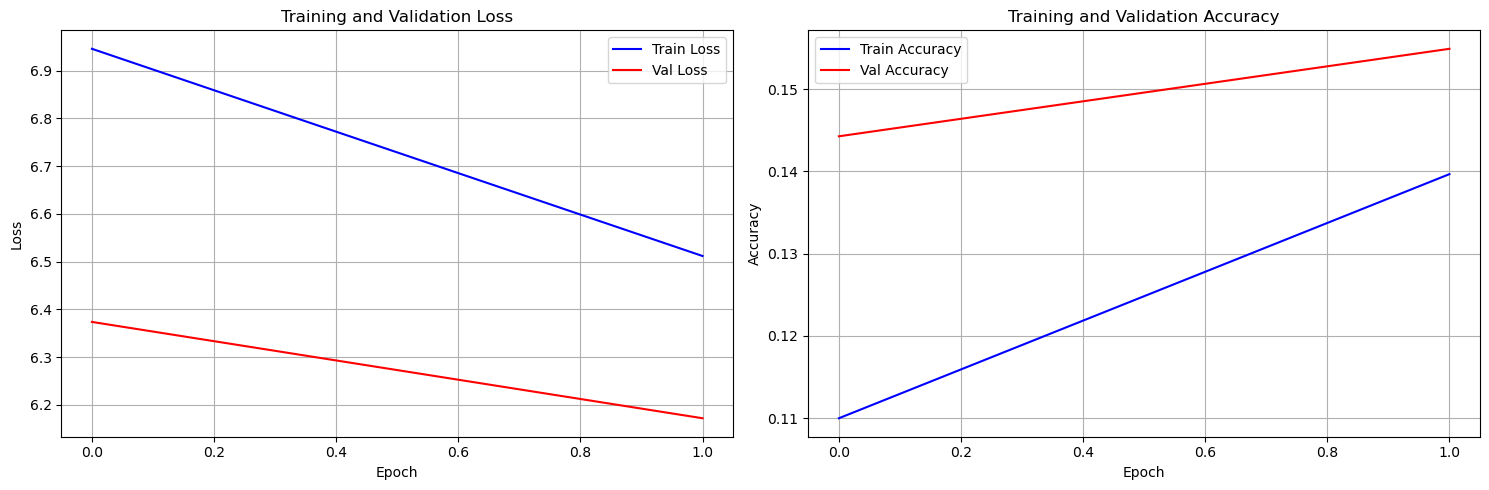


✅ Training completed!
📁 Model saved as 'gru_language_model.pth'
🎯 Final validation accuracy: 0.1549


In [10]:
# Train the GRU Language Model

import torch
import torch.nn as nn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0

    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} Training')

    for batch_idx, (sequences, targets) in enumerate(pbar):
        # Move data to device
        sequences = sequences.to(device)
        targets = targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits, hidden = model(sequences)

        # Calculate loss (predict next token from last timestep)
        last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
        loss = criterion(last_token_logits, targets)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        # May try 0.5 as the max_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        total_samples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(last_token_logits, dim=-1)
        correct_predictions += (predictions == targets).sum().item()

        # Update progress bar
        avg_loss = total_loss / (batch_idx + 1)
        accuracy = correct_predictions / total_samples
        pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Acc': f'{accuracy:.4f}'
        })

        # Print detailed stats every 1000 batches
        if (batch_idx + 1) % 1000 == 0:
            print(f'\nBatch {batch_idx+1}/{len(train_loader)}:')
            print(f'  Loss: {avg_loss:.4f}')
            print(f'  Accuracy: {accuracy:.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy


def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} Validation')

        for sequences, targets in pbar:
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Forward pass
            logits, hidden = model(sequences)

            # Calculate loss
            last_token_logits = logits[:, -1, :]
            loss = criterion(last_token_logits, targets)

            # Statistics
            total_loss += loss.item()
            total_samples += targets.size(0)

            # Calculate accuracy
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_predictions += (predictions == targets).sum().item()

            # Update progress bar
            avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else 0
            accuracy = correct_predictions / total_samples
            pbar.set_postfix({
                'Val Loss': f'{avg_loss:.4f}',
                'Val Acc': f'{accuracy:.4f}'
            })

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Complete training loop"""

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print("-" * 60)

    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)

        # Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, epoch)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"✓ New best model saved! Val Loss: {val_loss:.4f}")

        # Record history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"  Time: {epoch_time:.2f}s")
        print("-" * 60)

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f}s")
    print(f"Best validation loss: {best_val_loss:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

def plot_training_history(history):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['val_losses'], label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Val Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Start training
print("🚀 Starting GRU Language Model Training...")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Training parameters
# Try 20+ epochs, with LR-Scheduler
num_epochs = 2

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

# Plot results
plot_training_history(history)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'vocab': vocab,
    'model_config': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'gru_language_model.pth')

print("\n✅ Training completed!")
print("📁 Model saved as 'gru_language_model.pth'")
print(f"🎯 Final validation accuracy: {history['val_accuracies'][-1]:.4f}")